# r4482 th-222 source in 1/3 top position

In [1]:
import datetime
print(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

2017-07-13 15:29:40


In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
import sys
import os
import time
import tables as tb
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from invisible_cities.database import load_db

In [5]:
import invisible_cities.icaro.mpl_functions as mpl
import invisible_cities.reco.tbl_functions as tbl
from invisible_cities.reco.params import S12Params, ThresholdParams
from   invisible_cities.core.system_of_units_c import units

In [6]:
from invisible_cities.icaro.mpl_functions import plot_pmt_waveforms, plot_pmt_signals_vs_time_mus, \
              plot_signal_vs_time_mus

In [7]:
from invisible_cities.icaro.pmaps_mpl import plot_s12

In [8]:
from invisible_cities.sierpe                 import blr

In [9]:
from invisible_cities.reco                   import peak_functions_c as cpf

In [12]:
from invisible_cities.types.ic_types_c          import minmax

### Run Parameters

In [13]:
run_number = 4482

In [14]:
DataPMT = load_db.DataPMT(run_number)
DataSiPM = load_db.DataSiPM(run_number)
xs = DataSiPM.X.values
ys = DataSiPM.Y.values

pmt_active = np.nonzero(DataPMT.Active.values)[0].tolist()
coeff_c    = abs(DataPMT.coeff_c.values)
coeff_blr  = abs(DataPMT.coeff_blr.values)
adc_to_pes = abs(DataPMT.adc_to_pes.values)

In [15]:
RWF_file = os.path.join(os.environ['IC_DATA'],
                        'LSC/wvfms/{}/dst_waves.gdcsnext.000_{}.root.h5'.format(run_number, run_number))
print('RWF file = {}'.format(RWF_file))

RWF file = /Users/jjgomezcadenas/Projects/ICDATA/LSC/wvfms/4482/dst_waves.gdcsnext.000_4482.root.h5


In [16]:
DataPMT

,SensorID,ChannelID,PmtID,Active,X,Y,coeff_blr,coeff_c,adc_to_pes,noise_rms,Sigma
0,0,18,PMT1,1,-23.9414,65.7785,0.000788,0.000002,25.67,0.75,11.24
1,1,22,PMT3,1,-44.9951,-53.6231,0.000789,0.000002,26.47,0.78,12.21
2,2,19,PMT2,1,68.9365,-12.1554,0.000775,0.000002,28.61,0.75,10.52
3,3,23,PMT4,1,0.0000,185.0000,0.000778,0.000002,26.15,0.73,10.01
4,4,9,PMTC,1,-118.9160,141.7180,0.000789,0.000002,27.13,0.80,9.70
5,5,8,PMTB,1,-182.1890,32.1249,0.000781,0.000002,21.80,0.78,8.18
6,6,5,PMTA,1,-160.2150,-92.5000,0.000794,0.000002,24.59,0.76,8.98
7,7,4,PMT9,1,-63.2737,-173.8430,0.000773,0.000002,34.97,0.77,13.29
8,8,1,PMT8,1,63.2737,-173.8430,0.000788,0.000002,22.23,0.81,8.32
9,10,31,PMT6,1,182.1890,32.1249,0.000782,0.000002,20.85,0.79,8.07


In [17]:
pmt_active

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [18]:
h5rwf = tb.open_file(RWF_file,'r')

In [19]:
pmtrwf, pmtblr, sipmrwf = tbl.get_vectors(h5rwf)

In [20]:
NEVT, NPMT, PMTWL = pmtrwf.shape
NEVT, NSIPM, SIPMWL = sipmrwf.shape
print("""
        Number of events in file = {}
        Number of PMTs = {}
        PMTWL = {}
        Number of SiPMs = {}
        SiPMWL = {}
      """.format(NEVT, NPMT, PMTWL,NSIPM, SIPMWL))


        Number of events in file = 112
        Number of PMTs = 12
        PMTWL = 80000
        Number of SiPMs = 1792
        SiPMWL = 2000
      


In [27]:
s1par = S12Params(time = minmax(min   =  0 * units.mus,
                                max   = 990 * units.mus),
                      length = minmax(min =   6,
                                      max =  20),
                      stride              =   4,
                      rebin               = False)

In [44]:
s2par = S12Params(time = minmax(min   =    990 * units.mus,
                                    max   =   2000 * units.mus),
                      length = minmax(min =     200,
                                      max = 200000),
                      stride              =     40,
                      rebin               = True)

In [36]:
thr = ThresholdParams(thr_s1   =  3 * units.pes,
                      thr_s2   =  2   * units.pes,
                      thr_MAU  =  3   * units.adc,
                      thr_sipm =  1.5   * units.pes,
                      thr_SIPM = 10   * units.pes )

In [54]:
def deconv(event, n_baseline=78000, t_max=2000, signal_min =-100, signal_max=2000):
    CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = n_baseline,
                      thr_trigger           =     5,
                      acum_discharge_length =  5000)
    plot_pmt_signals_vs_time_mus(CWF,
                             pmt_active,
                             t_min      =    0,
                             t_max      = t_max,
                             signal_min = signal_min,
                             signal_max = signal_max)
    return CWF
    

In [56]:
def calsum(CWF, t_max=2000, signal_min =-100, signal_max=2000):
    csum, csum_mau =      cpf.calibrated_pmt_sum(CWF,
                                                 adc_to_pes,
                                                 pmt_active = pmt_active,
                                                 n_MAU = 100,
                                                 thr_MAU =   3)
    plot_signal_vs_time_mus(csum, 
                            t_min=0, 
                            t_max      = t_max,
                            signal_min = signal_min,
                            signal_max = signal_max)
    return csum, csum_mau

In [59]:
def pmaps(csum, csum_mau):
    s2_ene, s2_indx = cpf.wfzs(csum, threshold=thr.thr_s2)
    s1_ene, s1_indx = cpf.wfzs(csum_mau, threshold=thr.thr_s1)
    s1 = cpf.find_s1(csum, s1_indx, **s1par._asdict())
    s2 = cpf.find_s2(csum, s2_indx, **s2par._asdict())
    return s1, s2

#### events

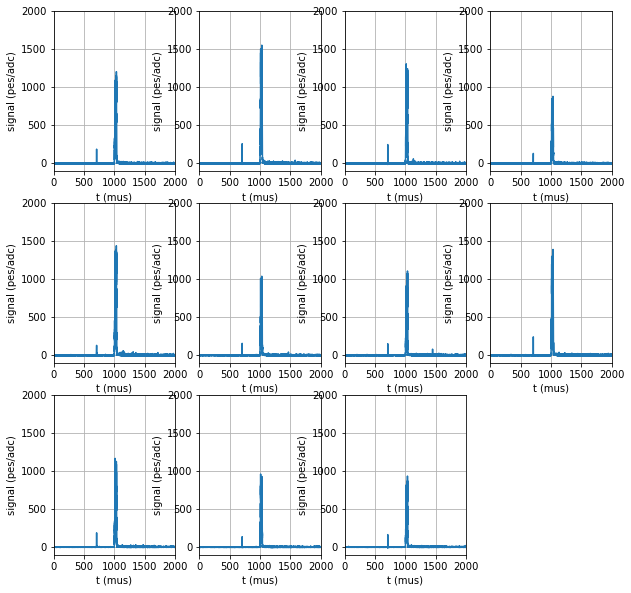

In [55]:
event=0
CWF = deconv(event, n_baseline=78000, t_max=2000, signal_min =-100, signal_max=2000)


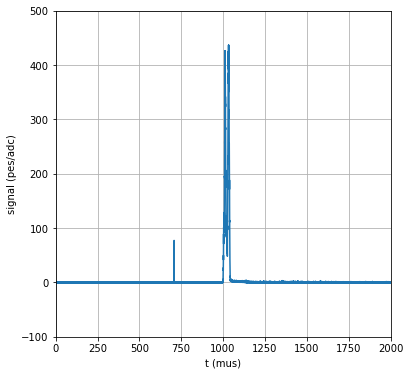

In [58]:
csum, csum_mau = calsum(CWF, t_max=2000, signal_min =-100, signal_max=500)

In [60]:
s1, s2 = pmaps(csum, csum_mau)

In [61]:
s1

S1 (number of peaks = 1)
peak number = 0: Peak(samples = 14 width =      0.3 mus , energy =    438.0 pes
        height =     77.2 pes tmin-tmax = minmax(min=707.45, max=707.775) mus  

In [62]:
s2

S2 (number of peaks = 1)
peak number = 0: Peak(samples = 66 width =     64.9 mus , energy = 321296.1 pes
        height =  16699.8 pes tmin-tmax = minmax(min=998.5125, max=1063.4125) mus  

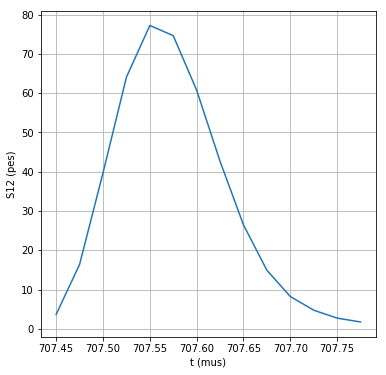

In [63]:
plot_s12(s1, figsize=(6,6))

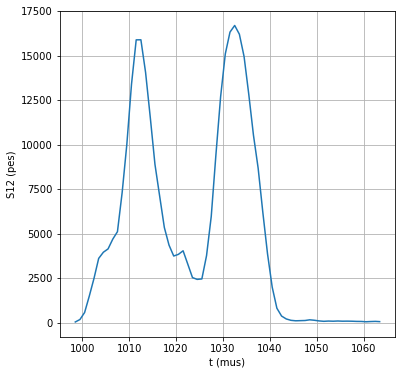

In [64]:
plot_s12(s2, figsize=(6,6))

S1 (number of peaks = 1)
peak number = 0: Peak(samples = 19 width =      0.5 mus , energy =    347.7 pes
        height =     54.5 pes tmin-tmax = minmax(min=986.775, max=987.225) mus  

S2 (number of peaks = 1)
peak number = 0: Peak(samples = 50 width =     48.9 mus , energy = 318288.9 pes
        height =  24819.0 pes tmin-tmax = minmax(min=999.6125000000001, max=1048.5) mus  



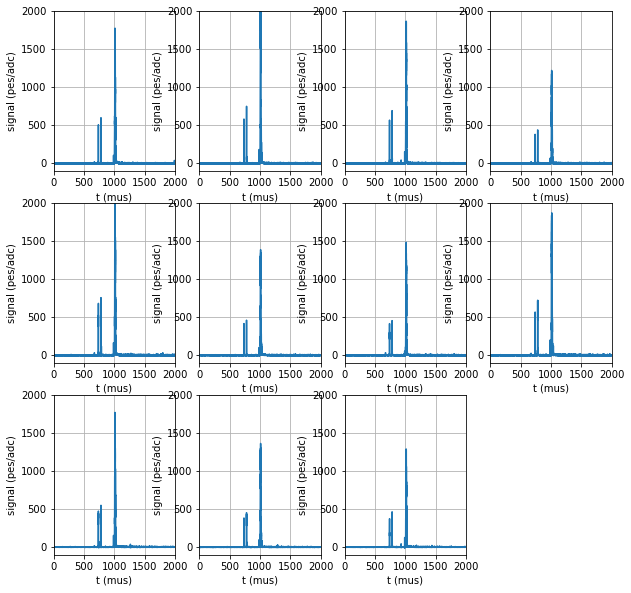

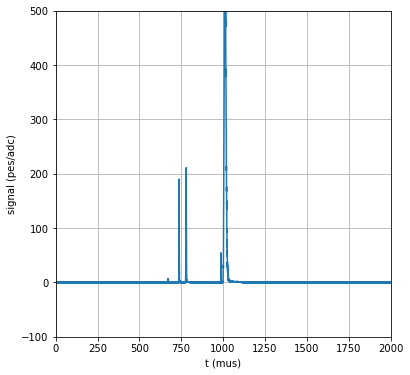

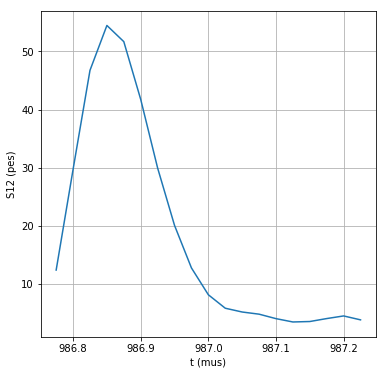

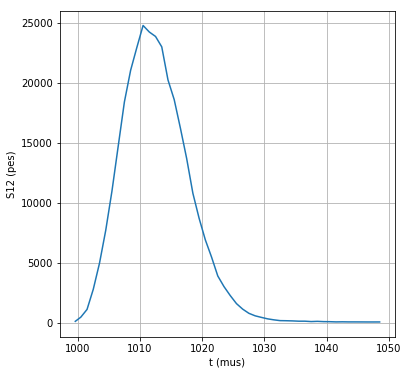

In [68]:
event=1
CWF = deconv(event, n_baseline=78000, t_max=2000, signal_min =-100, signal_max=2000)
csum, csum_mau = calsum(CWF, t_max=2000, signal_min =-100, signal_max=500)
s1, s2 = pmaps(csum, csum_mau)
print(s1)
print(s2)
if s1.number_of_peaks: 
    plot_s12(s1)
if s2.number_of_peaks: 
    plot_s12(s2)

S1 (number of peaks = 1)
peak number = 0: Peak(samples = 9 width =      0.2 mus , energy =     27.7 pes
        height =      3.7 pes tmin-tmax = minmax(min=199.9, max=200.1) mus  

S2 (number of peaks = 0)



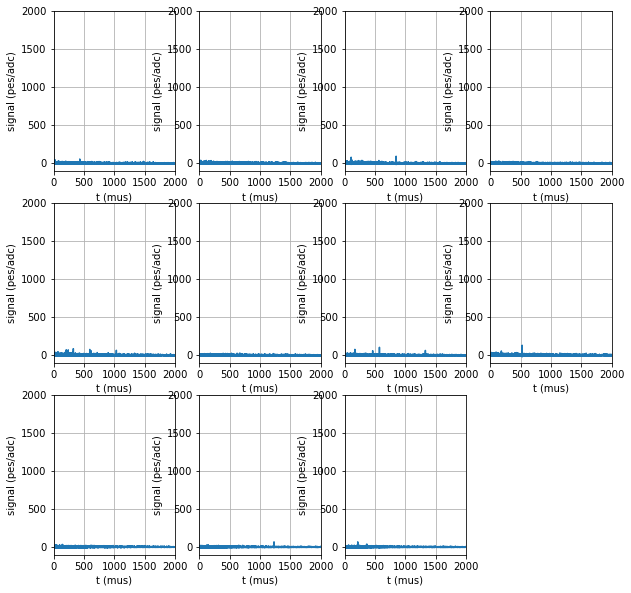

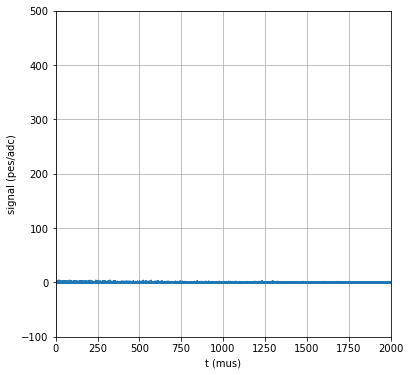

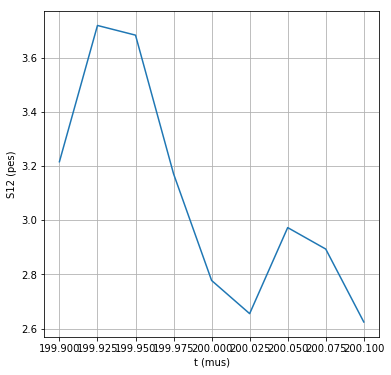

In [69]:
event=2
CWF = deconv(event, n_baseline=78000, t_max=2000, signal_min =-100, signal_max=2000)
csum, csum_mau = calsum(CWF, t_max=2000, signal_min =-100, signal_max=500)
s1, s2 = pmaps(csum, csum_mau)
print(s1)
print(s2)
if s1.number_of_peaks: 
    plot_s12(s1)
if s2.number_of_peaks: 
    plot_s12(s2)

S1 (number of peaks = 1)
peak number = 0: Peak(samples = 12 width =      0.3 mus , energy =    548.0 pes
        height =     93.4 pes tmin-tmax = minmax(min=566.075, max=566.35) mus  

S2 (number of peaks = 2)
peak number = 0: Peak(samples = 128 width =    126.4 mus , energy = 321646.6 pes
        height =  10241.1 pes tmin-tmax = minmax(min=998.8625000000001, max=1125.3) mus  
peak number = 1: Peak(samples = 13 width =     11.7 mus , energy =   3841.9 pes
        height =    705.8 pes tmin-tmax = minmax(min=1845.6000000000001, max=1857.275) mus  



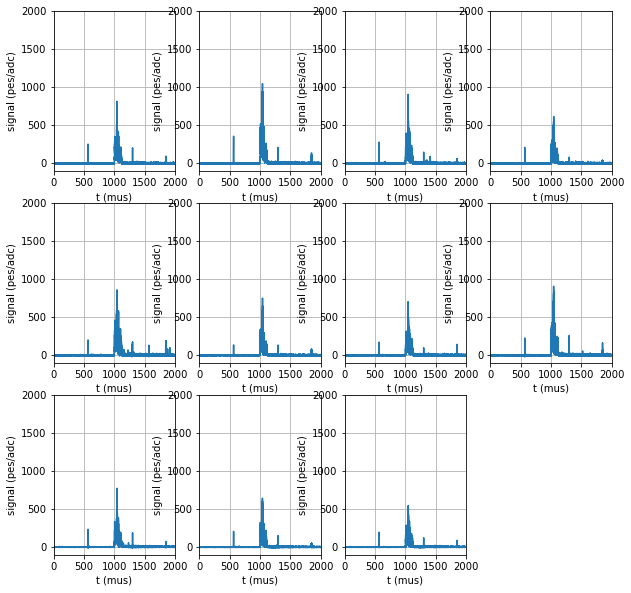

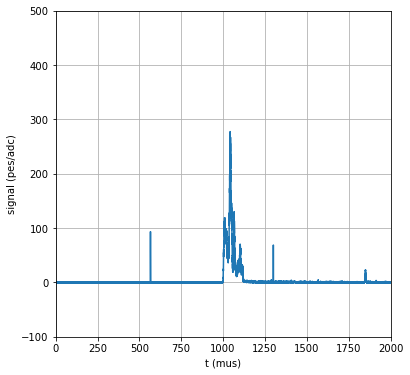

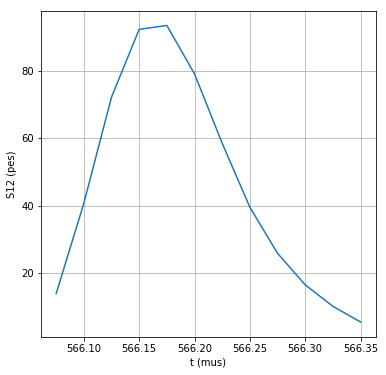

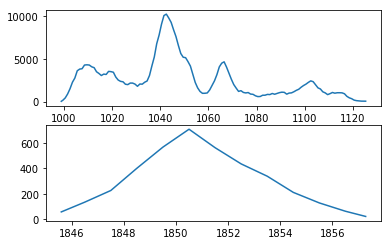

In [70]:
event=3
CWF = deconv(event, n_baseline=78000, t_max=2000, signal_min =-100, signal_max=2000)
csum, csum_mau = calsum(CWF, t_max=2000, signal_min =-100, signal_max=500)
s1, s2 = pmaps(csum, csum_mau)
print(s1)
print(s2)
if s1.number_of_peaks: 
    plot_s12(s1)
if s2.number_of_peaks: 
    plot_s12(s2)

S1 (number of peaks = 1)
peak number = 0: Peak(samples = 11 width =      0.2 mus , energy =    351.0 pes
        height =     61.9 pes tmin-tmax = minmax(min=829.375, max=829.625) mus  

S2 (number of peaks = 2)
peak number = 0: Peak(samples = 72 width =     70.3 mus , energy = 317798.8 pes
        height =  12377.6 pes tmin-tmax = minmax(min=998.85, max=1069.1625) mus  
peak number = 1: Peak(samples = 7 width =      5.6 mus , energy =    434.2 pes
        height =     80.5 pes tmin-tmax = minmax(min=1070.7125, max=1076.3) mus  



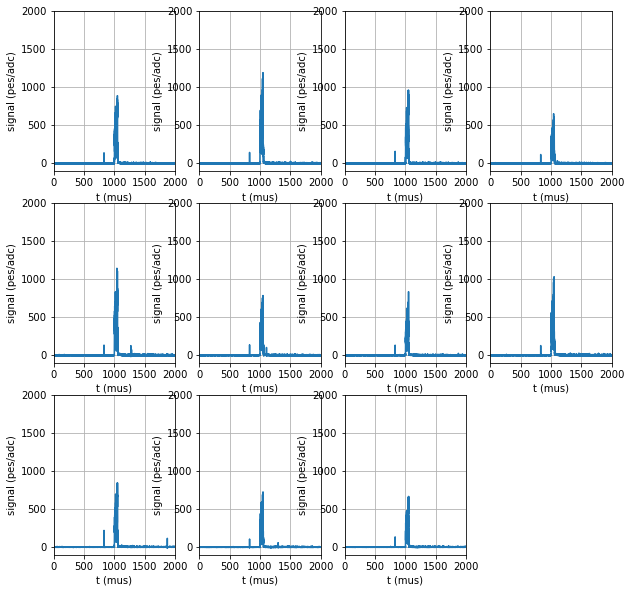

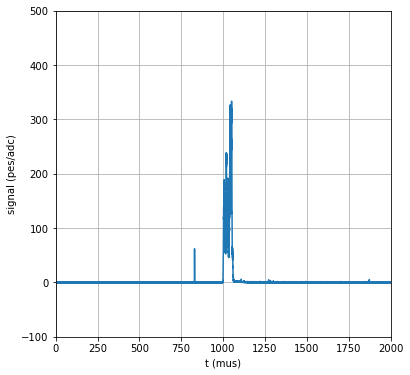

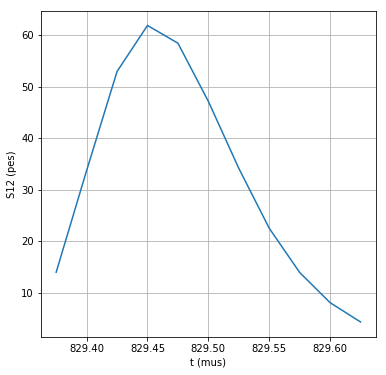

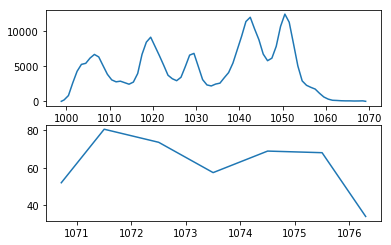

In [71]:
event=4
CWF = deconv(event, n_baseline=78000, t_max=2000, signal_min =-100, signal_max=2000)
csum, csum_mau = calsum(CWF, t_max=2000, signal_min =-100, signal_max=500)
s1, s2 = pmaps(csum, csum_mau)
print(s1)
print(s2)
if s1.number_of_peaks: 
    plot_s12(s1)
if s2.number_of_peaks: 
    plot_s12(s2)

S1 (number of peaks = 3)
peak number = 0: Peak(samples = 13 width =      0.3 mus , energy =    539.7 pes
        height =     93.8 pes tmin-tmax = minmax(min=325.5, max=325.8) mus  
peak number = 1: Peak(samples = 15 width =      0.3 mus , energy =    445.2 pes
        height =     69.3 pes tmin-tmax = minmax(min=671.375, max=671.725) mus  
peak number = 2: Peak(samples = 6 width =      0.1 mus , energy =     27.0 pes
        height =      5.4 pes tmin-tmax = minmax(min=878.8000000000001, max=878.9250000000001) mus  

S2 (number of peaks = 1)
peak number = 0: Peak(samples = 13 width =     11.5 mus , energy =   3064.3 pes
        height =    480.6 pes tmin-tmax = minmax(min=1216.6000000000001, max=1228.1000000000001) mus  



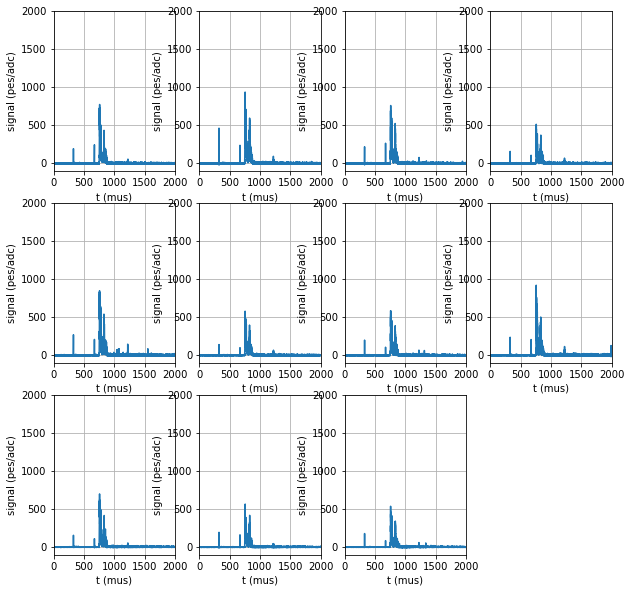

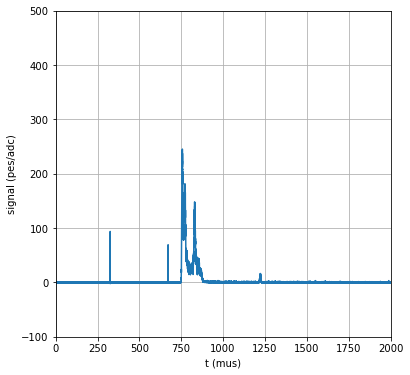

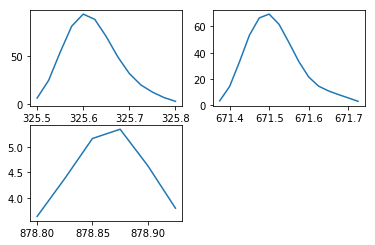

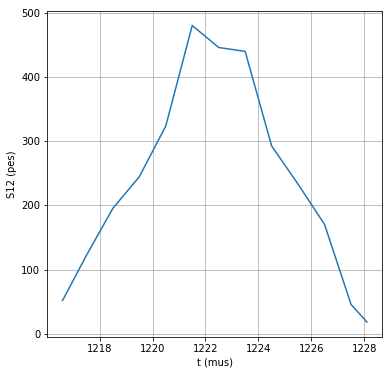

In [72]:
event=5
CWF = deconv(event, n_baseline=78000, t_max=2000, signal_min =-100, signal_max=2000)
csum, csum_mau = calsum(CWF, t_max=2000, signal_min =-100, signal_max=500)
s1, s2 = pmaps(csum, csum_mau)
print(s1)
print(s2)
if s1.number_of_peaks: 
    plot_s12(s1)
if s2.number_of_peaks: 
    plot_s12(s2)

S1 (number of peaks = 1)
peak number = 0: Peak(samples = 14 width =      0.3 mus , energy =    407.3 pes
        height =     72.1 pes tmin-tmax = minmax(min=600.9250000000001, max=601.25) mus  

S2 (number of peaks = 1)
peak number = 0: Peak(samples = 63 width =     61.7 mus , energy = 282904.2 pes
        height =  16972.4 pes tmin-tmax = minmax(min=998.625, max=1060.325) mus  



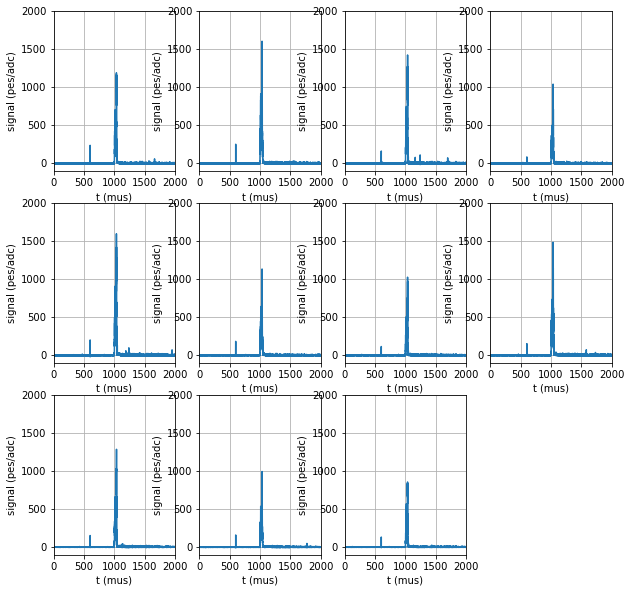

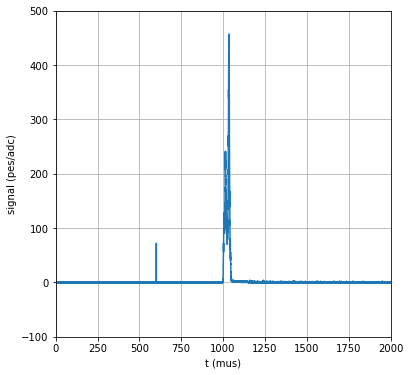

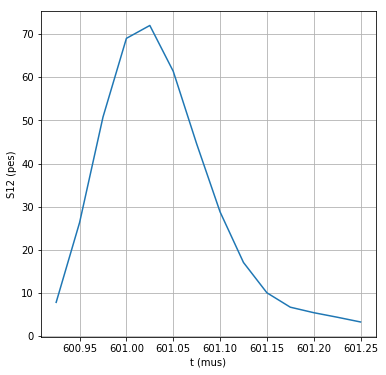

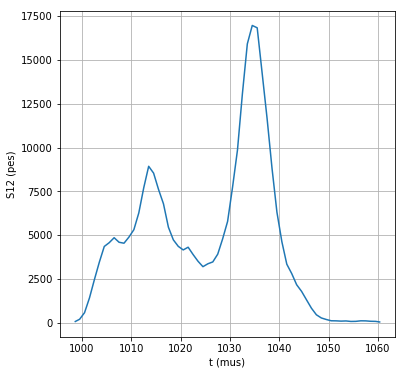

In [73]:
event=6
CWF = deconv(event, n_baseline=78000, t_max=2000, signal_min =-100, signal_max=2000)
csum, csum_mau = calsum(CWF, t_max=2000, signal_min =-100, signal_max=500)
s1, s2 = pmaps(csum, csum_mau)
print(s1)
print(s2)
if s1.number_of_peaks: 
    plot_s12(s1)
if s2.number_of_peaks: 
    plot_s12(s2)

S1 (number of peaks = 3)
peak number = 0: Peak(samples = 13 width =      0.3 mus , energy =    389.8 pes
        height =     69.1 pes tmin-tmax = minmax(min=556.725, max=557.025) mus  
peak number = 1: Peak(samples = 11 width =      0.2 mus , energy =     43.8 pes
        height =      5.7 pes tmin-tmax = minmax(min=844.775, max=845.025) mus  
peak number = 2: Peak(samples = 6 width =      0.1 mus , energy =     20.9 pes
        height =      3.7 pes tmin-tmax = minmax(min=845.5500000000001, max=845.6750000000001) mus  

S2 (number of peaks = 0)



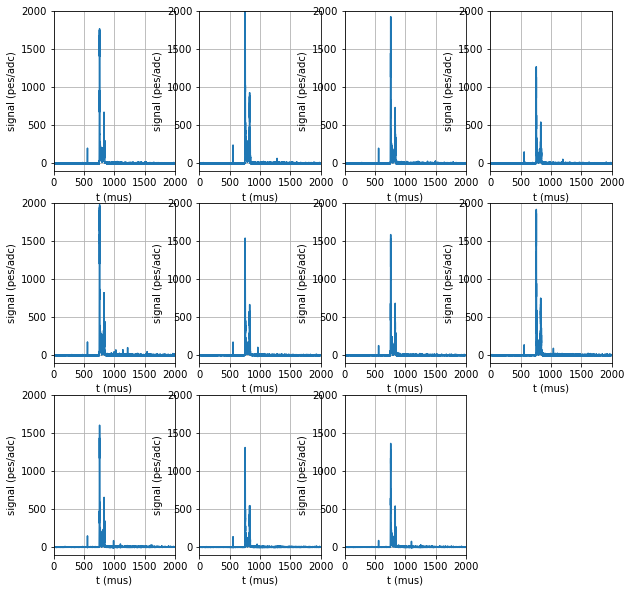

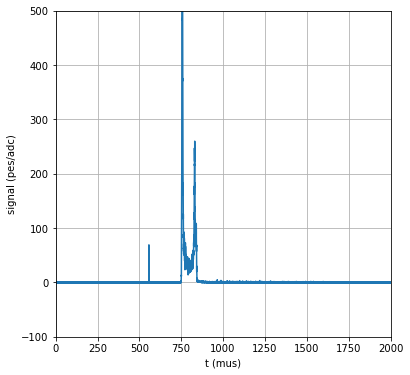

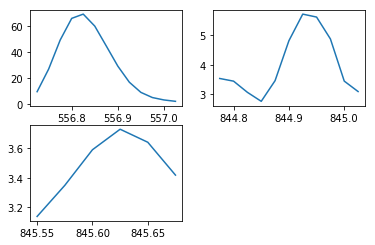

In [74]:
event=7
CWF = deconv(event, n_baseline=78000, t_max=2000, signal_min =-100, signal_max=2000)
csum, csum_mau = calsum(CWF, t_max=2000, signal_min =-100, signal_max=500)
s1, s2 = pmaps(csum, csum_mau)
print(s1)
print(s2)
if s1.number_of_peaks: 
    plot_s12(s1)
if s2.number_of_peaks: 
    plot_s12(s2)

S1 (number of peaks = 0)

S2 (number of peaks = 2)
peak number = 0: Peak(samples = 284 width =    282.5 mus , energy = 686476.1 pes
        height =  40582.3 pes tmin-tmax = minmax(min=990.9375, max=1273.4) mus  
peak number = 1: Peak(samples = 548 width =    546.9 mus , energy =  57954.8 pes
        height =    135.7 pes tmin-tmax = minmax(min=1452.575, max=1999.5) mus  



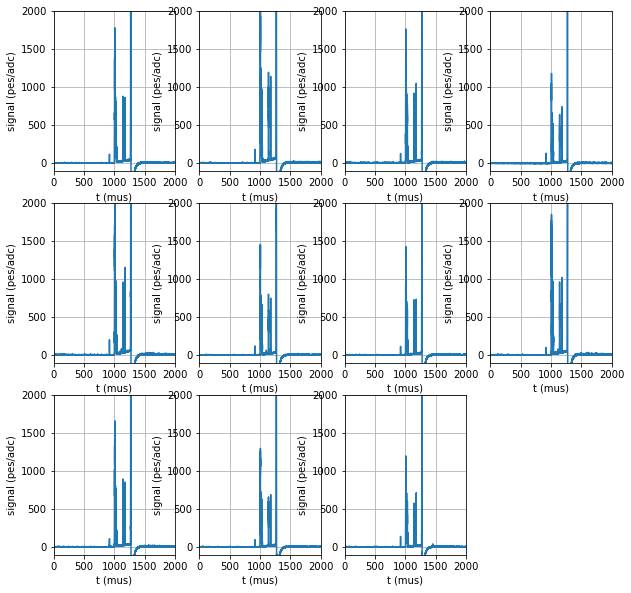

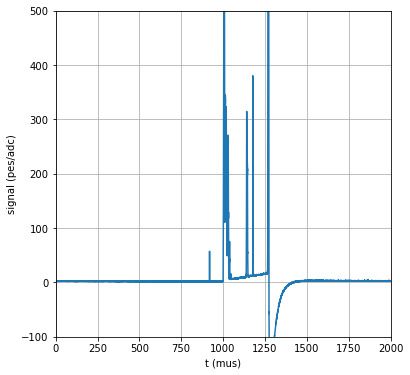

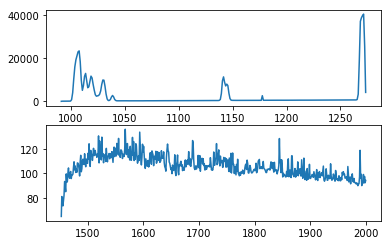

In [75]:
event=8
CWF = deconv(event, n_baseline=78000, t_max=2000, signal_min =-100, signal_max=2000)
csum, csum_mau = calsum(CWF, t_max=2000, signal_min =-100, signal_max=500)
s1, s2 = pmaps(csum, csum_mau)
print(s1)
print(s2)
if s1.number_of_peaks: 
    plot_s12(s1)
if s2.number_of_peaks: 
    plot_s12(s2)

S1 (number of peaks = 0)

S2 (number of peaks = 2)
peak number = 0: Peak(samples = 1202 width =   1200.5 mus , energy = 1272342.2 pes
        height =  46010.2 pes tmin-tmax = minmax(min=0.5, max=1201.025) mus  
peak number = 1: Peak(samples = 642 width =    640.7 mus , energy = 113411.5 pes
        height =    235.0 pes tmin-tmax = minmax(min=1358.8375, max=1999.5) mus  



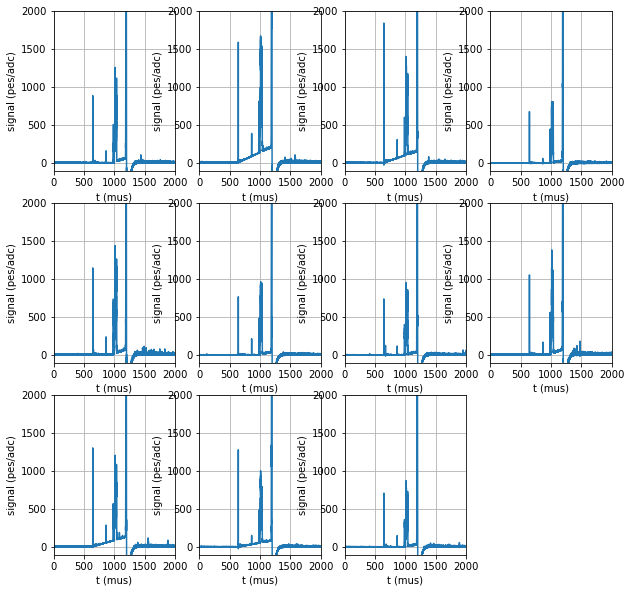

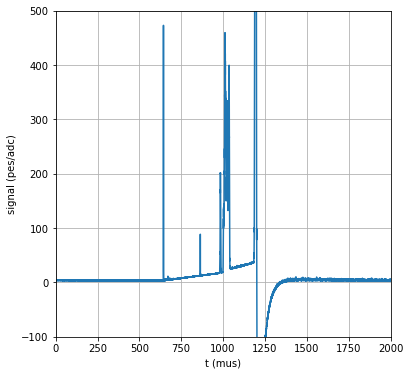

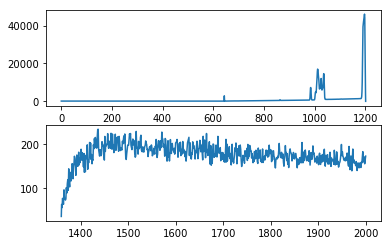

In [76]:
event=9
CWF = deconv(event, n_baseline=78000, t_max=2000, signal_min =-100, signal_max=2000)
csum, csum_mau = calsum(CWF, t_max=2000, signal_min =-100, signal_max=500)
s1, s2 = pmaps(csum, csum_mau)
print(s1)
print(s2)
if s1.number_of_peaks: 
    plot_s12(s1)
if s2.number_of_peaks: 
    plot_s12(s2)

S1 (number of peaks = 1)
peak number = 0: Peak(samples = 13 width =      0.3 mus , energy =    351.9 pes
        height =     60.3 pes tmin-tmax = minmax(min=892.475, max=892.775) mus  

S2 (number of peaks = 1)
peak number = 0: Peak(samples = 57 width =     55.4 mus , energy = 350300.4 pes
        height =  19578.1 pes tmin-tmax = minmax(min=999.6125000000001, max=1055.0125) mus  



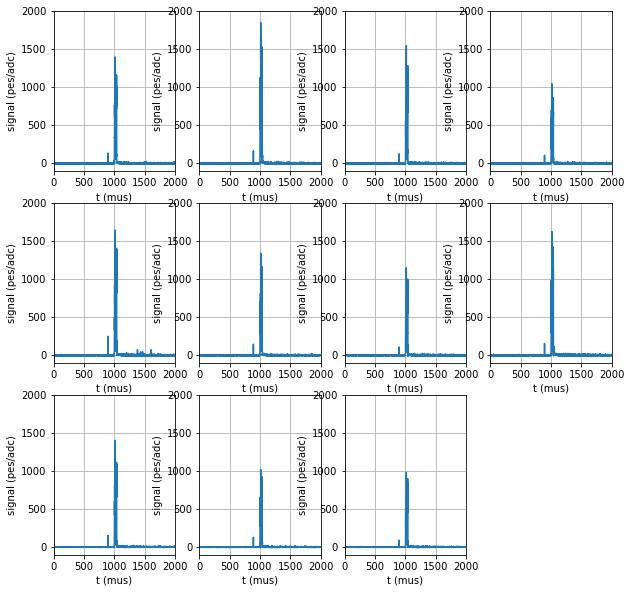

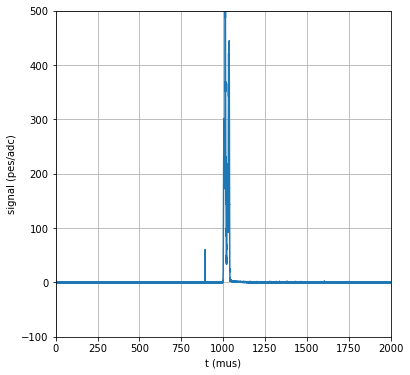

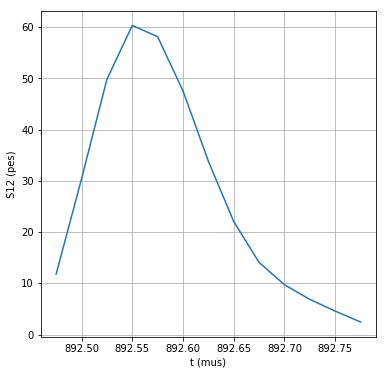

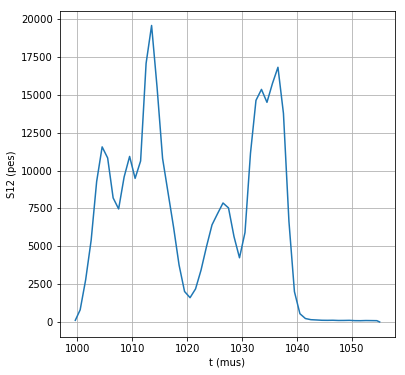

In [77]:
event=10
CWF = deconv(event, n_baseline=78000, t_max=2000, signal_min =-100, signal_max=2000)
csum, csum_mau = calsum(CWF, t_max=2000, signal_min =-100, signal_max=500)
s1, s2 = pmaps(csum, csum_mau)
print(s1)
print(s2)
if s1.number_of_peaks: 
    plot_s12(s1)
if s2.number_of_peaks: 
    plot_s12(s2)

S1 (number of peaks = 1)
peak number = 0: Peak(samples = 13 width =      0.3 mus , energy =    489.6 pes
        height =     84.6 pes tmin-tmax = minmax(min=812.075, max=812.375) mus  

S2 (number of peaks = 1)
peak number = 0: Peak(samples = 81 width =     79.7 mus , energy = 379328.1 pes
        height =  24040.7 pes tmin-tmax = minmax(min=999.6, max=1079.3125) mus  



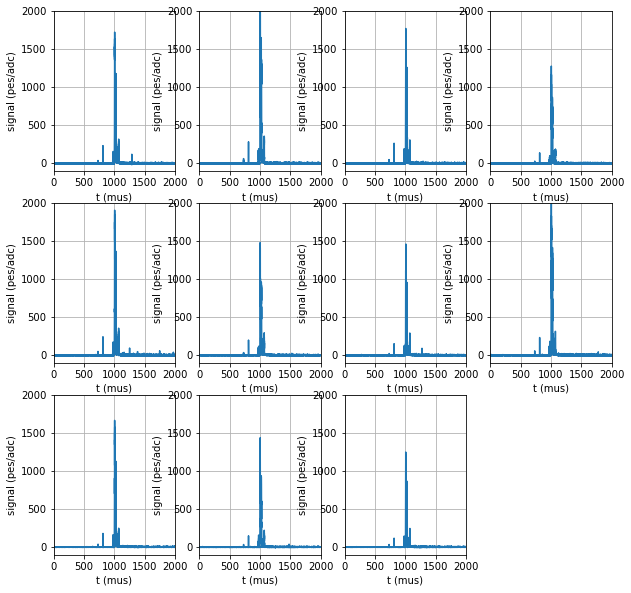

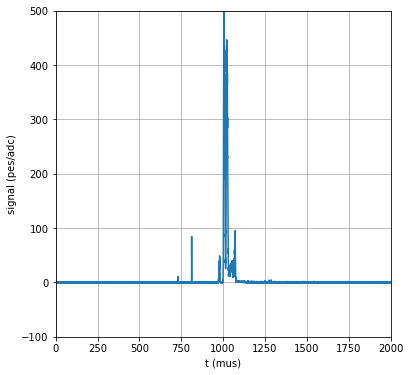

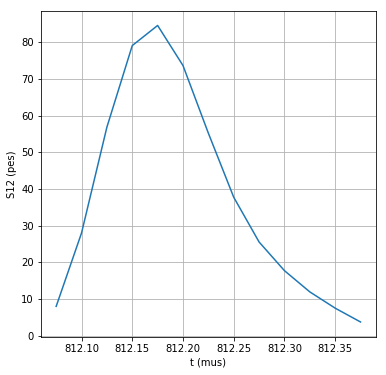

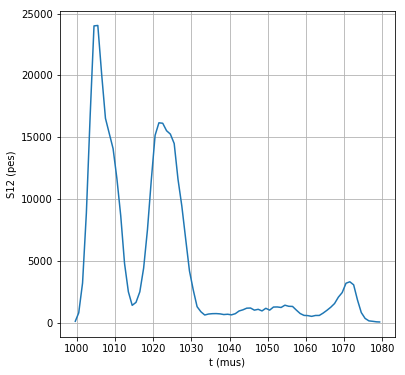

In [78]:
event=11
CWF = deconv(event, n_baseline=78000, t_max=2000, signal_min =-100, signal_max=2000)
csum, csum_mau = calsum(CWF, t_max=2000, signal_min =-100, signal_max=500)
s1, s2 = pmaps(csum, csum_mau)
print(s1)
print(s2)
if s1.number_of_peaks: 
    plot_s12(s1)
if s2.number_of_peaks: 
    plot_s12(s2)

S1 (number of peaks = 0)

S2 (number of peaks = 0)



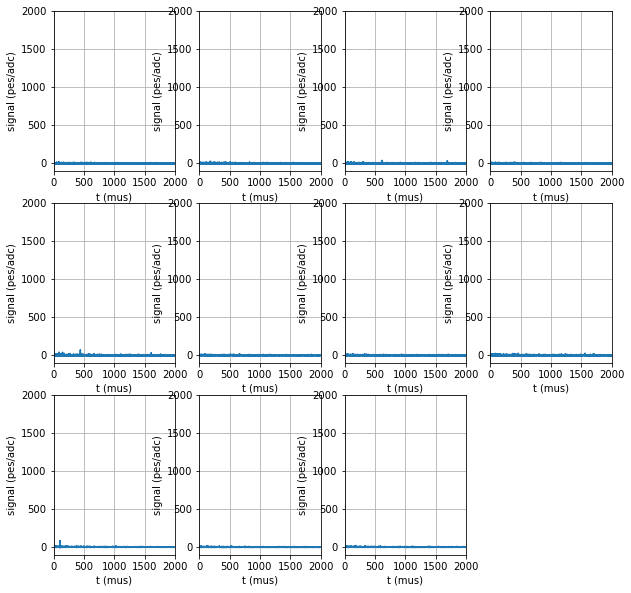

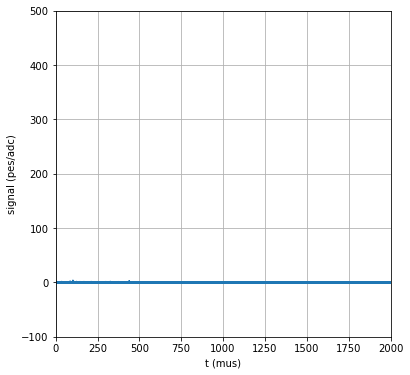

In [79]:
event=12
CWF = deconv(event, n_baseline=78000, t_max=2000, signal_min =-100, signal_max=2000)
csum, csum_mau = calsum(CWF, t_max=2000, signal_min =-100, signal_max=500)
s1, s2 = pmaps(csum, csum_mau)
print(s1)
print(s2)
if s1.number_of_peaks: 
    plot_s12(s1)
if s2.number_of_peaks: 
    plot_s12(s2)

S1 (number of peaks = 1)
peak number = 0: Peak(samples = 12 width =      0.3 mus , energy =    301.1 pes
        height =     48.6 pes tmin-tmax = minmax(min=935.475, max=935.75) mus  

S2 (number of peaks = 1)
peak number = 0: Peak(samples = 77 width =     75.7 mus , energy = 348417.7 pes
        height =  27313.0 pes tmin-tmax = minmax(min=999.5500000000001, max=1075.225) mus  



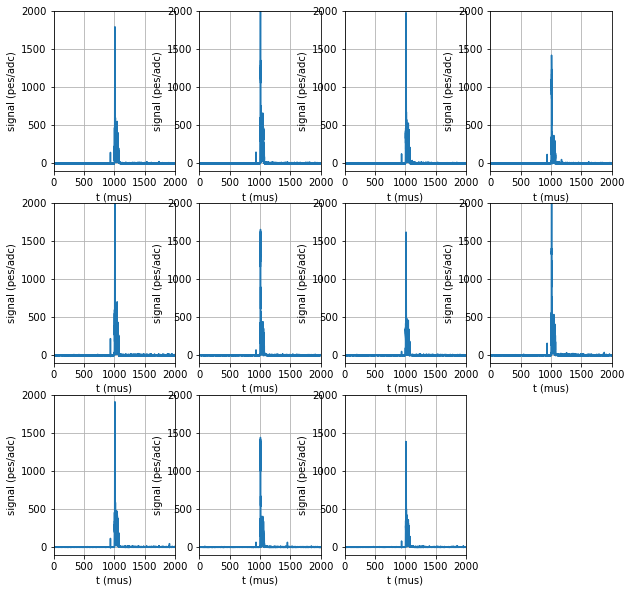

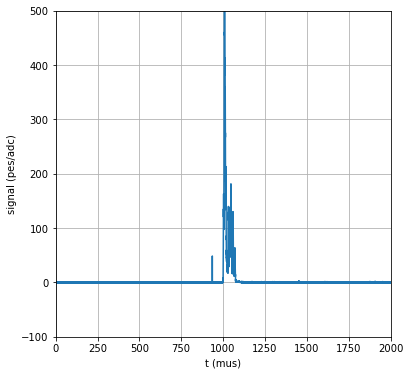

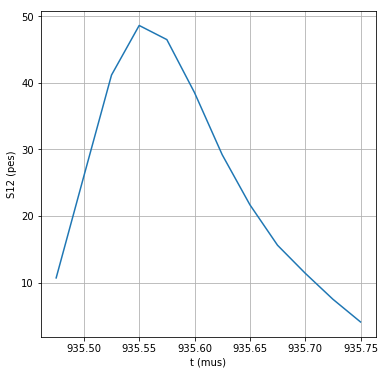

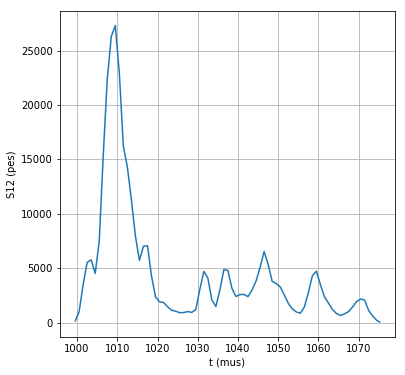

In [80]:
event=13
CWF = deconv(event, n_baseline=78000, t_max=2000, signal_min =-100, signal_max=2000)
csum, csum_mau = calsum(CWF, t_max=2000, signal_min =-100, signal_max=500)
s1, s2 = pmaps(csum, csum_mau)
print(s1)
print(s2)
if s1.number_of_peaks: 
    plot_s12(s1)
if s2.number_of_peaks: 
    plot_s12(s2)

S1 (number of peaks = 1)
peak number = 0: Peak(samples = 16 width =      0.4 mus , energy =    460.3 pes
        height =     78.4 pes tmin-tmax = minmax(min=900.1750000000001, max=900.5500000000001) mus  

S2 (number of peaks = 1)
peak number = 0: Peak(samples = 103 width =    101.5 mus , energy = 455726.7 pes
        height =  18920.4 pes tmin-tmax = minmax(min=999.825, max=1101.3125) mus  



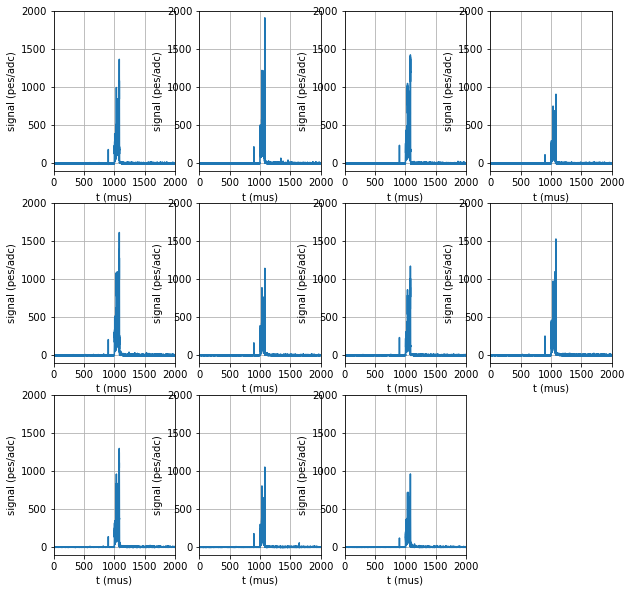

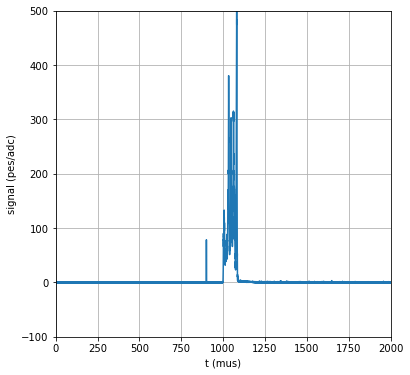

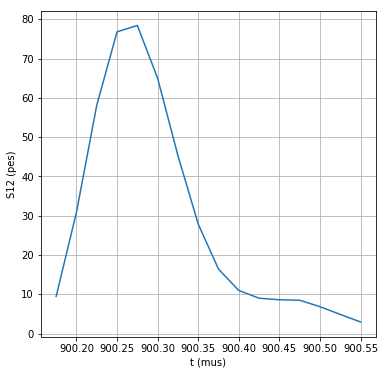

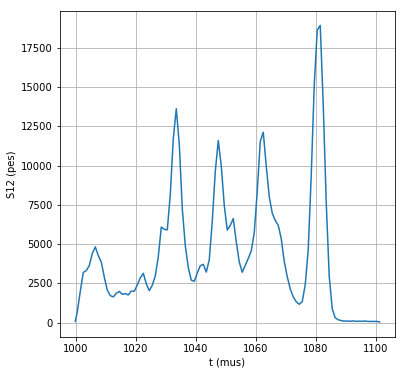

In [81]:
event=14
CWF = deconv(event, n_baseline=78000, t_max=2000, signal_min =-100, signal_max=2000)
csum, csum_mau = calsum(CWF, t_max=2000, signal_min =-100, signal_max=500)
s1, s2 = pmaps(csum, csum_mau)
print(s1)
print(s2)
if s1.number_of_peaks: 
    plot_s12(s1)
if s2.number_of_peaks: 
    plot_s12(s2)

S1 (number of peaks = 1)
peak number = 0: Peak(samples = 13 width =      0.3 mus , energy =    355.6 pes
        height =     61.8 pes tmin-tmax = minmax(min=836.95, max=837.25) mus  

S2 (number of peaks = 1)
peak number = 0: Peak(samples = 65 width =     63.4 mus , energy = 349099.5 pes
        height =  13733.2 pes tmin-tmax = minmax(min=999.6125000000001, max=1063.025) mus  



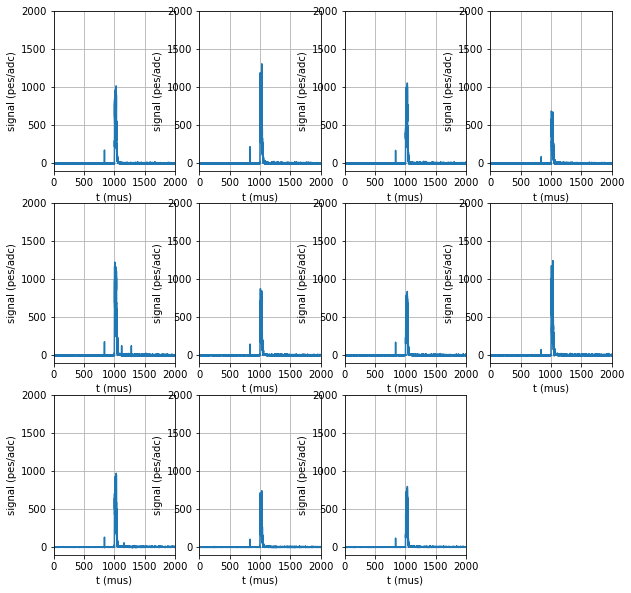

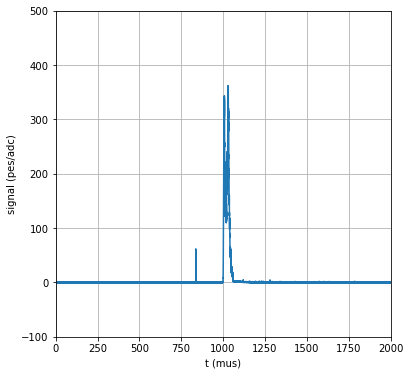

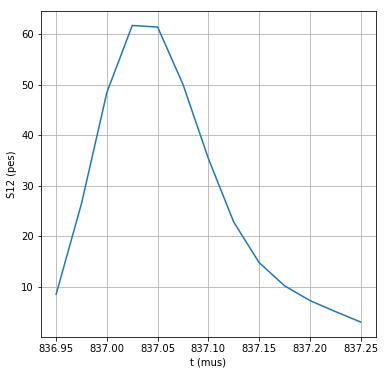

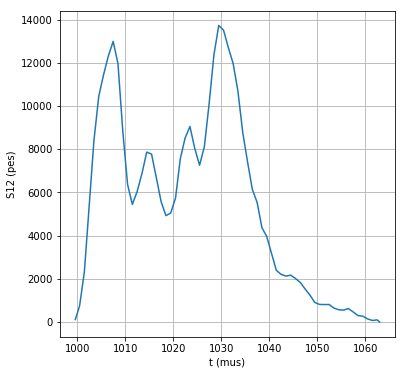

In [82]:
event=15
CWF = deconv(event, n_baseline=78000, t_max=2000, signal_min =-100, signal_max=2000)
csum, csum_mau = calsum(CWF, t_max=2000, signal_min =-100, signal_max=500)
s1, s2 = pmaps(csum, csum_mau)
print(s1)
print(s2)
if s1.number_of_peaks: 
    plot_s12(s1)
if s2.number_of_peaks: 
    plot_s12(s2)

S1 (number of peaks = 1)
peak number = 0: Peak(samples = 6 width =      0.1 mus , energy =     19.2 pes
        height =      3.4 pes tmin-tmax = minmax(min=30.375, max=30.5) mus  

S2 (number of peaks = 0)



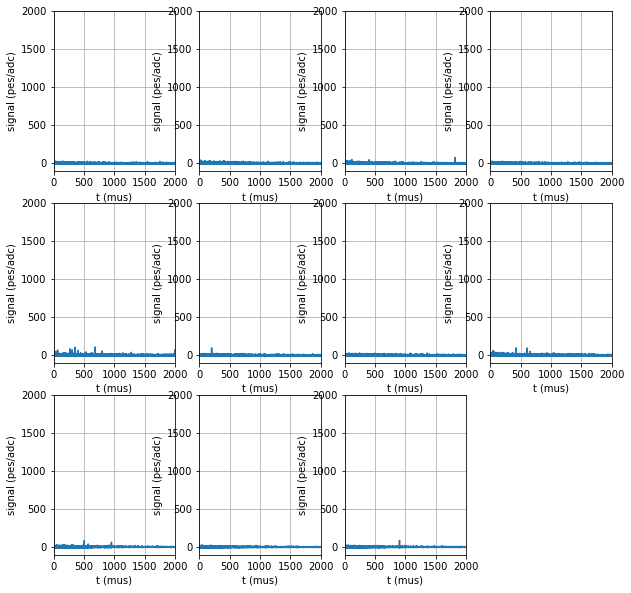

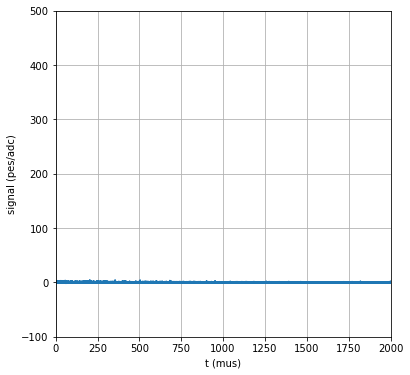

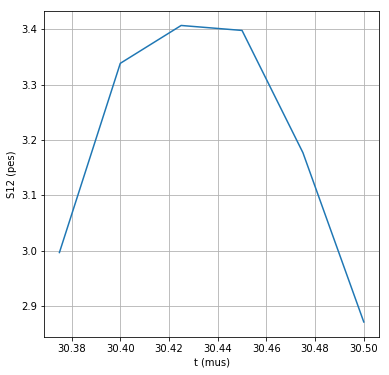

In [83]:
event=16
CWF = deconv(event, n_baseline=78000, t_max=2000, signal_min =-100, signal_max=2000)
csum, csum_mau = calsum(CWF, t_max=2000, signal_min =-100, signal_max=500)
s1, s2 = pmaps(csum, csum_mau)
print(s1)
print(s2)
if s1.number_of_peaks: 
    plot_s12(s1)
if s2.number_of_peaks: 
    plot_s12(s2)

S1 (number of peaks = 1)
peak number = 0: Peak(samples = 13 width =      0.3 mus , energy =    420.9 pes
        height =     75.5 pes tmin-tmax = minmax(min=806.5, max=806.8000000000001) mus  

S2 (number of peaks = 1)
peak number = 0: Peak(samples = 72 width =     70.7 mus , energy = 370139.6 pes
        height =  23884.0 pes tmin-tmax = minmax(min=999.5375, max=1070.275) mus  



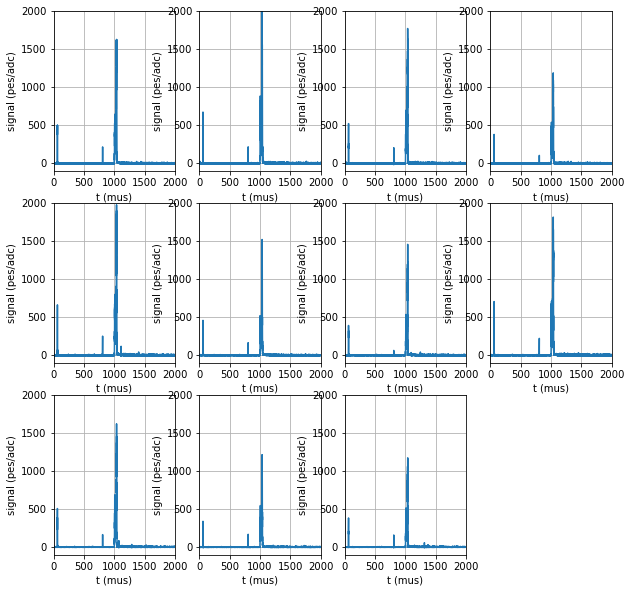

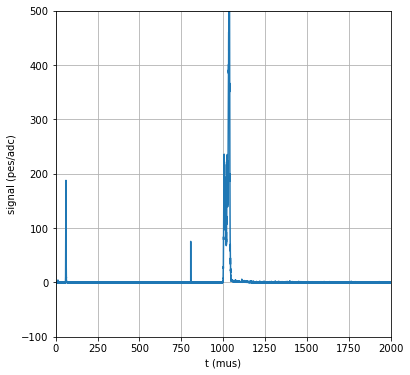

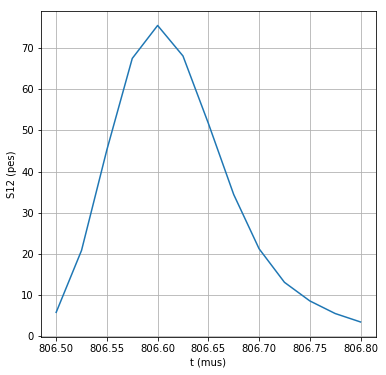

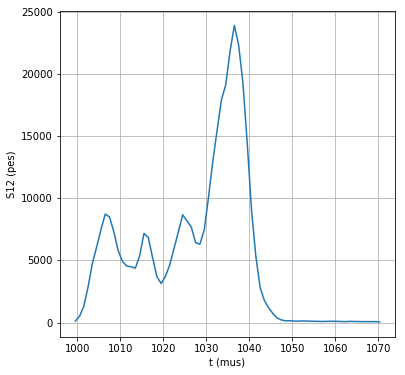

In [84]:
event=17
CWF = deconv(event, n_baseline=78000, t_max=2000, signal_min =-100, signal_max=2000)
csum, csum_mau = calsum(CWF, t_max=2000, signal_min =-100, signal_max=500)
s1, s2 = pmaps(csum, csum_mau)
print(s1)
print(s2)
if s1.number_of_peaks: 
    plot_s12(s1)
if s2.number_of_peaks: 
    plot_s12(s2)

S1 (number of peaks = 0)

S2 (number of peaks = 3)
peak number = 0: Peak(samples = 169 width =    167.6 mus , energy = 840418.9 pes
        height =  42336.0 pes tmin-tmax = minmax(min=999.5125, max=1167.1000000000001) mus  
peak number = 1: Peak(samples = 10 width =      8.3 mus , energy =    537.9 pes
        height =     84.2 pes tmin-tmax = minmax(min=1528.825, max=1537.0875) mus  
peak number = 2: Peak(samples = 9 width =      7.6 mus , energy =    465.4 pes
        height =     65.3 pes tmin-tmax = minmax(min=1544.55, max=1552.1375) mus  



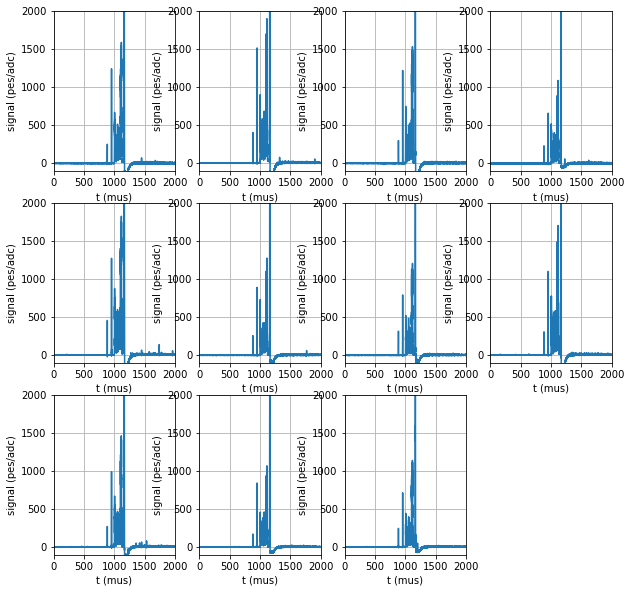

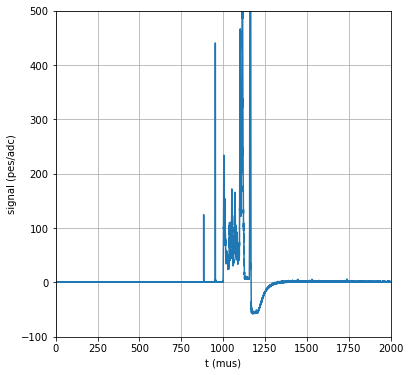

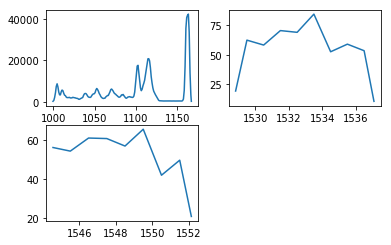

In [85]:
event=18
CWF = deconv(event, n_baseline=78000, t_max=2000, signal_min =-100, signal_max=2000)
csum, csum_mau = calsum(CWF, t_max=2000, signal_min =-100, signal_max=500)
s1, s2 = pmaps(csum, csum_mau)
print(s1)
print(s2)
if s1.number_of_peaks: 
    plot_s12(s1)
if s2.number_of_peaks: 
    plot_s12(s2)

S1 (number of peaks = 1)
peak number = 0: Peak(samples = 14 width =      0.3 mus , energy =    335.0 pes
        height =     59.6 pes tmin-tmax = minmax(min=946.7, max=947.025) mus  

S2 (number of peaks = 1)
peak number = 0: Peak(samples = 73 width =     71.4 mus , energy = 365384.7 pes
        height =  26229.0 pes tmin-tmax = minmax(min=999.775, max=1071.2125) mus  



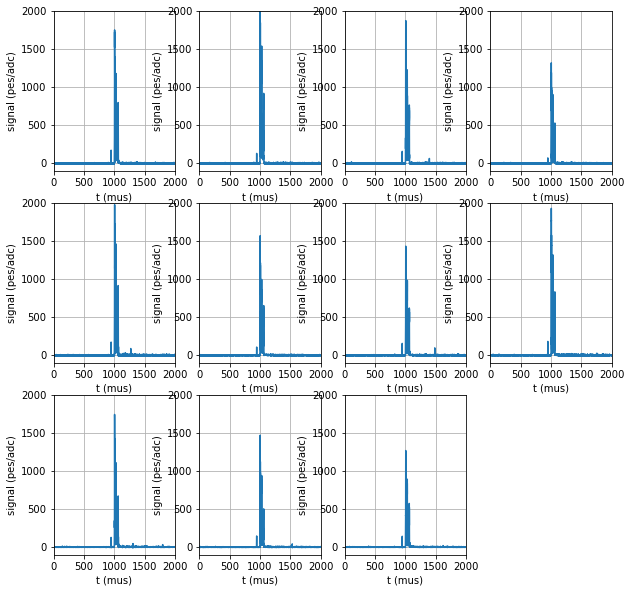

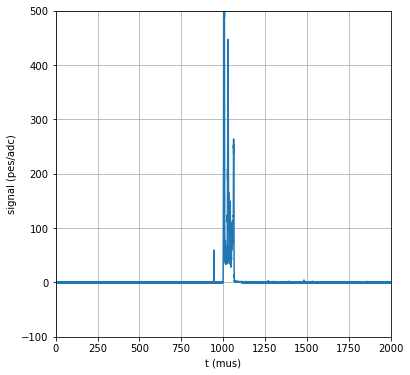

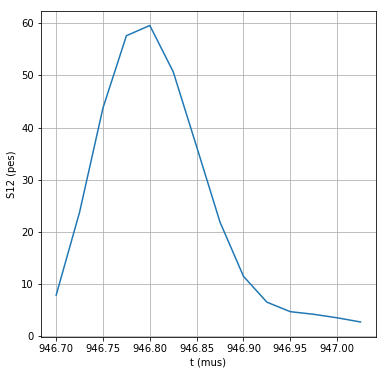

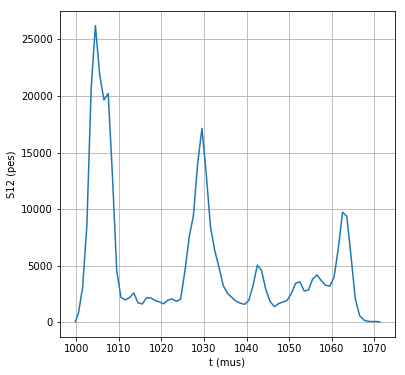

In [86]:
event=19
CWF = deconv(event, n_baseline=78000, t_max=2000, signal_min =-100, signal_max=2000)
csum, csum_mau = calsum(CWF, t_max=2000, signal_min =-100, signal_max=500)
s1, s2 = pmaps(csum, csum_mau)
print(s1)
print(s2)
if s1.number_of_peaks: 
    plot_s12(s1)
if s2.number_of_peaks: 
    plot_s12(s2)

S1 (number of peaks = 1)
peak number = 0: Peak(samples = 12 width =      0.3 mus , energy =    288.0 pes
        height =     51.4 pes tmin-tmax = minmax(min=956.4250000000001, max=956.7) mus  

S2 (number of peaks = 1)
peak number = 0: Peak(samples = 55 width =     53.8 mus , energy = 295716.2 pes
        height =  23819.4 pes tmin-tmax = minmax(min=999.65, max=1053.4375) mus  



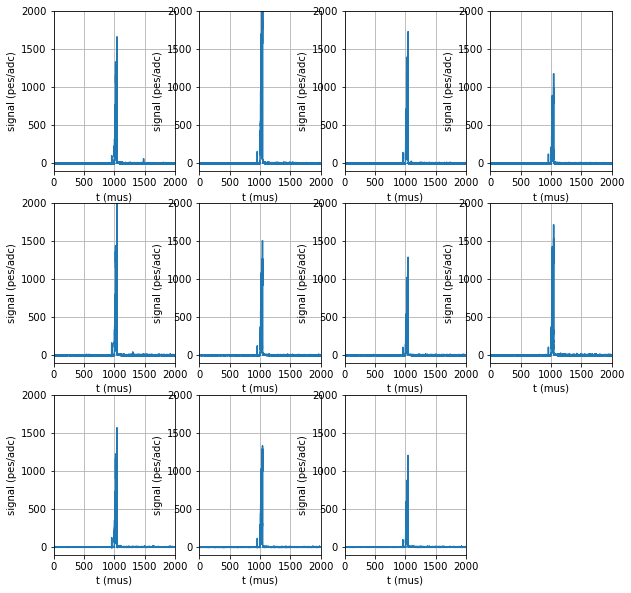

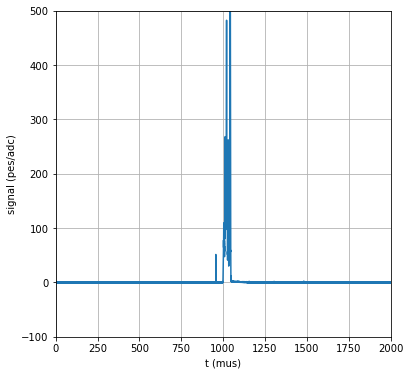

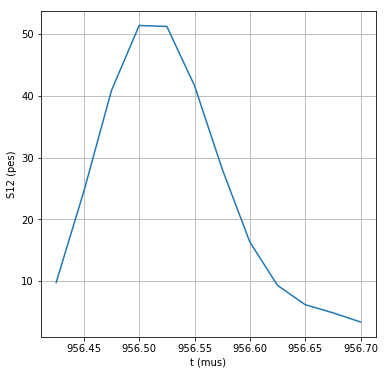

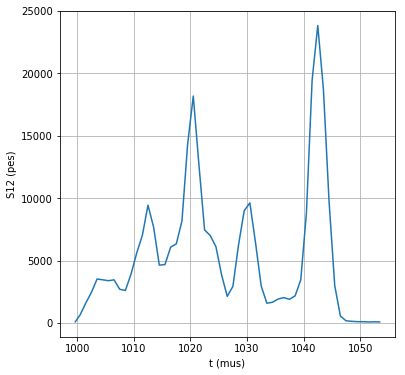

In [87]:
event=20
CWF = deconv(event, n_baseline=78000, t_max=2000, signal_min =-100, signal_max=2000)
csum, csum_mau = calsum(CWF, t_max=2000, signal_min =-100, signal_max=500)
s1, s2 = pmaps(csum, csum_mau)
print(s1)
print(s2)
if s1.number_of_peaks: 
    plot_s12(s1)
if s2.number_of_peaks: 
    plot_s12(s2)

### Summary:

good events: 14
empty:        3
shifted:      1
alphas:       3


In [88]:
good = 14/21

In [89]:
good

0.6666666666666666